# 하이브리드 검색(Hybrid Search)

---

## 1. 개념 이해

### 1.1 검색 방식 분류

#### 🔍 **의미론적 검색 (Semantic Search)**
- **정의**: 벡터 임베딩을 활용한 의미 기반 검색
- **특징**: 
  - 동의어와 문맥적 의미를 파악
  - 자연어 질의에 효과적
  - 유사도 기반 매칭
- **장점**: 의미적 연관성이 높은 문서 검색
- **단점**: 정확한 키워드 매칭 약함

#### 🔍 **키워드 검색 (Keyword Search)**
- **정의**: BM25 알고리즘 기반 키워드 매칭 검색
- **특징**:
  - 직접적인 단어/구문 매칭
  - 계산 효율성 높음
  - 전통적인 정보검색 방식
- **장점**: 정확한 키워드 매칭, 빠른 처리 속도
- **단점**: 의미적 유사성 파악 제한적

#### 🔍 **하이브리드 검색 (Hybrid Search)**
- **정의**: 키워드 검색과 의미론적 검색의 결합
- **특징**:
  - EnsembleRetriever를 통한 구현
  - 가중치 조정으로 성능 최적화
  - 두 검색 방식의 시너지 효과
- **장점**: 포괄적이고 정확한 검색 결과
- **단점**: 구현 복잡도 증가, 계산 비용 상승

### 1.2 BM25 알고리즘 이해

BM25는 TF-IDF의 확장된 버전으로, 다음 공식을 사용합니다:

```markdown
BM25(qi, D) = IDF(qi) × (f(qi, D) × (k1 + 1)) / (f(qi, D) + k1 × (1 - b + b × |D| / avgdl))
```

- `f(qi, D)`: 문서 D에서 단어 qi의 빈도
- `|D|`: 문서 D의 길이
- `avgdl`: 평균 문서 길이
- `k1, b`: 조정 매개변수

---

## 2. 환경 설정

### 2.1 필수 라이브러리 설치

```bash
# 기본 라이브러리
pip install langchain langchain-community langchain-openai
pip install langchain-chroma

# 검색 및 평가 라이브러리
pip install rank_bm25 kiwipiepy
pip install ranx pytrec-eval ranx-k

# 데이터 처리
pip install pandas numpy matplotlib seaborn
```

### 2.2 환경 변수 설정

In [1]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

True

### 2.3 기본 라이브러리 Import

In [3]:
import os
import json
from glob import glob
from pprint import pprint
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 인식 - Windows
import matplotlib 
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
matplotlib.rc('font', family=font_name)

# # 한글 폰트 인식 - Mac
# import matplotlib
# matplotlib.rc('font', family='AppleGothic')

# 마이너스 부호 인식
matplotlib.rc("axes", unicode_minus = False)

# LangChain 핵심
from langchain_core.documents import Document
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 데이터 처리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 한국어 처리
from kiwipiepy import Kiwi

# 평가
import ranx
# import pytrec_eval

---

## 3. 데이터 준비

### 3.1 텍스트 데이터 로드

In [4]:
def load_text_files(file_patterns):
    """
    다양한 형식의 텍스트 파일을 로드
    
    Args:
        file_patterns (list): 파일 패턴 리스트
    
    Returns:
        list: Document 객체 리스트
    """
    documents = []
    
    for pattern in file_patterns:
        files = glob(pattern)
        for file_path in files:
            try:
                loader = TextLoader(file_path, encoding='utf-8')
                docs = loader.load()
                documents.extend(docs)
                print(f"✅ {file_path} 로드 완료")
            except Exception as e:
                print(f"❌ {file_path} 로드 실패: {e}")
    
    return documents

# 로드할 문서의 패턴 정의
# 예시: 'data/*.txt', 'data/*.json' 등
# 현재는 'data/*_KR.md' 패턴만 사용
file_patterns = [
    'data/*_KR.md',
    # 'data/*.txt',
    # 'data/*.json'
]
raw_documents = load_text_files(file_patterns)
print(f"총 {len(raw_documents)}개 문서 로드됨")

✅ data\리비안_KR.md 로드 완료
✅ data\테슬라_KR.md 로드 완료
총 2개 문서 로드됨


### 3.2 문서 분할 및 전처리

In [5]:
def create_text_splitter():
    """
    한국어 최적화된 텍스트 분할기 생성
    """
    return RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        separators=['\n\n', '\n', r'(?<=[.!?])\s+'],
        chunk_size=300,
        chunk_overlap=50,
        is_separator_regex=True,
        keep_separator=True,
    )

def preprocess_documents(documents, company_mapping=None):
    """
    문서 전처리 및 메타데이터 추가
    
    Args:
        documents (list): 원본 문서 리스트
        company_mapping (dict): 회사명 매핑 정보
    
    Returns:
        list: 전처리된 Document 객체 리스트
    """
    text_splitter = create_text_splitter()
    chunks = text_splitter.split_documents(documents)
    
    processed_docs = []
    for chunk in chunks:
        # 메타데이터 추가
        source_file = chunk.metadata.get('source', '')
        
        # 회사명 추출
        if company_mapping:
            company = 'unknown'
            for keyword, name in company_mapping.items():
                if keyword in source_file.lower():
                    company = name
                    break
        else:
            company = 'default'
        
        # Document 객체 생성
        doc = Document(
            page_content=f"<Document>\n{chunk.page_content}\n</Document>\n<Source>이 문서는 '{company}'에 대한 문서입니다.</Source>",
            metadata={
                **chunk.metadata,
                'company': company,
                'language': 'ko',
                'chunk_length': len(chunk.page_content)
            }
        )
        processed_docs.append(doc)
    
    return processed_docs

# 회사명 매핑 정보
# 예시: 'tesla' -> '테슬라', 'rivian' -> '리비안'
# 실제 사용 시에는 더 많은 회사명을 추가할 수 있음
company_mapping = {
    '테슬라': '테슬라(tesla)',
    '리비안': '리비안(rivian)',
}

processed_docs = preprocess_documents(raw_documents, company_mapping)
print(f"총 {len(processed_docs)}개 청크 생성됨")

총 39개 청크 생성됨


In [6]:
# 결과 확인
for i, doc in enumerate(processed_docs[:3]+ processed_docs[-3:]):
    print(f"\n[청크 {i+1}]")
    print(f"회사: {doc.metadata['company']}")
    print(f"내용: {doc.page_content}")
    print("-" * 50)


[청크 1]
회사: 리비안(rivian)
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 '리비안(rivian)'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 2]
회사: 리비안(rivian)
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러
</Document>
<Source>이 문서는 '리비안(rivian)'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 3]
회사: 리비안(rivian)
내용: <Document>
- **총 자산 (2023):** 168억 미국 달러
- **총 자본 (2023):** 91억 4천만 미국 달러
- **직원 수 (2023년 12월):** 16,790명
- **웹사이트:** rivian.com
</Document>
<Source>이 문서는 '리비안(rivian)'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 4

---

## 4. 검색 방법론

### 4.1 의미론적 검색 (Semantic Search)

#### 4.1.1 벡터 저장소 생성

In [7]:
import os
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

def create_or_load_vector_store(documents, collection_name="hybrid_search_db"):
    """
    Chroma 벡터 저장소 생성 (기존 컬렉션이 있으면 로드하고, 없으면 새로 생성)
    
    Args:
        documents (list): Document 객체 리스트
        collection_name (str): 컬렉션 이름
    
    Returns:
        Chroma: 벡터 저장소 객체

    """
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    persist_directory = "./local_chroma_db"
    
    # 디렉토리와 컬렉션 파일이 존재하는지 확인
    if os.path.exists(persist_directory):
        try:
            # 기존 컬렉션 로드 시도
            vector_store = Chroma(
                collection_name=collection_name,
                embedding_function=embeddings,
                persist_directory=persist_directory
            )
            
            # 컬렉션에 문서가 있는지 확인
            if vector_store._collection.count() > 0:
                print(f"✅ 기존 벡터 저장소 로드 완료: {vector_store._collection.count()}개 문서")
                return vector_store
        except Exception as e:
            print(f"기존 컬렉션 로드 실패: {e}")
    
    # 새로운 벡터 저장소 생성
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_directory,
        collection_metadata={'hnsw:space': 'cosine'}
    )
    print(f"✅ 새 벡터 저장소 생성 완료: {vector_store._collection.count()}개 문서")
    return vector_store

# 벡터 저장소 생성
vector_store = create_or_load_vector_store(processed_docs)

✅ 새 벡터 저장소 생성 완료: 39개 문서


#### 4.1.2 의미론적 검색 실행

In [8]:
def semantic_search(vector_store, query, k=5):
    """
    의미론적 검색 실행
    
    Args:
        vector_store: Chroma 벡터 저장소
        query (str): 검색 쿼리
        k (int): 반환할 문서 수
    
    Returns:
        list: 검색된 Document 객체 리스트
    """
    # 검색기 생성
    retriever = vector_store.as_retriever(search_kwargs={"k": k})
    
    # 검색 실행
    results = retriever.invoke(query)
        
    return results

# 검색 테스트
query = "리비안은 언제 설립되었나요?"
semantic_results = semantic_search(vector_store, query, k=3)

print(f"Query: {query}")
print(f"🔍 의미론적 검색 결과 ({len(semantic_results)}개)")
for i, doc in enumerate(semantic_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 의미론적 검색 결과 (3개)

[1] 회사: 리비안(rivian)
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
-...
--------------------------------------------------

[2] 회사: 리비안(rivian)
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 '리비안(rivian)'에 대한 문서입니...
--------------------------------------------------

[3] 회사: 리비안(rivian)
내용: <Document>
**역사**

**초창기 (2009–15):**

- 2009년 R. J. 스캐린지가 Mainstream Motors로 설립.
- 2011년 Rivian Automotive로 사명 변경.
- 처음에는 스포츠카 프로토타입(R1)에 집중했지만 전기 및 ...
--------------------------------------------------


### 4.2 키워드 검색 (Keyword Search)

#### 4.2.1 한국어 토크나이저 설정

In [9]:
def setup_korean_tokenizer():
    """
    한국어 토크나이저 설정
    
    Returns:
        Kiwi: 한국어 토크나이저 객체
    """
    kiwi = Kiwi()
    
    # 사용자 정의 단어 추가
    custom_words = [
        ('리비안', 'NNP'),  # 고유명사
        ('테슬라', 'NNP'),  # 고유명사
        ('전기차', 'NNG'),  # 일반명사
    ]
    
    for word, pos in custom_words:
        kiwi.add_user_word(word, pos)
        print(f"✅ 단어 추가: {word} ({pos})")
    
    return kiwi

def korean_tokenizer(text, kiwi_model):
    """
    한국어 토크나이저 함수
    
    Args:
        text (str): 토큰화할 텍스트
        kiwi_model: Kiwi 모델 객체
    
    Returns:
        list: 토큰 리스트
    """
    return [token.form for token in kiwi_model.tokenize(text)]

# 토크나이저 설정
kiwi_model = setup_korean_tokenizer()

# 토큰화 테스트
test_text = "리비안은 언제 설립되었나요?"
tokens = korean_tokenizer(test_text, kiwi_model)
print(f"원문: {test_text}")
print(f"토큰: {tokens}")

✅ 단어 추가: 리비안 (NNP)
✅ 단어 추가: 테슬라 (NNP)
✅ 단어 추가: 전기차 (NNG)
원문: 리비안은 언제 설립되었나요?
토큰: ['리비안', '은', '언제', '설립', '되', '었', '나요', '?']


#### 4.2.2 BM25 검색기 생성

In [11]:
def create_bm25_retriever(documents, kiwi_model, k=5):
    """
    BM25 검색기 생성
    
    Args:
        documents (list): Document 객체 리스트
        kiwi_model: Kiwi 토크나이저
        k (int): 반환할 문서 수
    
    Returns:
        BM25Retriever: BM25 검색기 객체
    """
    def preprocess_func(text):
        return korean_tokenizer(text, kiwi_model)
    
    # BM25 검색기 생성
    bm25_retriever = BM25Retriever.from_documents(
        documents=documents,
        preprocess_func=preprocess_func,
        k=k
    )
    
    print(f"✅ BM25 검색기 생성 완료: {len(documents)}개 문서 인덱싱")
    return bm25_retriever

# BM25 검색기 생성
bm25_retriever = create_bm25_retriever(processed_docs, kiwi_model, k=3)

✅ BM25 검색기 생성 완료: 39개 문서 인덱싱


In [12]:
query

'리비안은 언제 설립되었나요?'

In [13]:
# 검색 테스트
keyword_results = bm25_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 키워드 검색 결과 ({len(keyword_results)}개)")
for i, doc in enumerate(keyword_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 키워드 검색 결과 (3개)

[1] 회사: 테슬라(tesla)
내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energy를 설립했습니다. 2017년 2월, Tesla Motors는 사명을 Tesla, Inc....
--------------------------------------------------

[2] 회사: 테슬라(tesla)
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------

[3] 회사: 리비안(rivian)
내용: <Document>
**EV 충전**

Rivian은 미국과 캐나다 전역에 공공 충전소 네트워크를 개발하고 있습니다. Rivian은 2021년에 Waypoint 충전기 설치를 시작했지만 2023년 4월에 Rivian Adventure Network가 Rivian 이외의...
--------------------------------------------------


#### 4.2.3 BM25 점수 확인

In [14]:
def analyze_bm25_scores(bm25_retriever, query, kiwi_model, top_k=5):
    """
    BM25 점수 분석
    
    Args:
        bm25_retriever: BM25 검색기
        query (str): 검색 쿼리
        kiwi_model: Kiwi 토크나이저
        top_k (int): 상위 k개 결과
    """
    # 쿼리 토큰화
    tokenized_query = korean_tokenizer(query, kiwi_model)
    print(f"쿼리 토큰: {tokenized_query}")
    
    # BM25 점수 계산
    doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)
    
    # 점수 정렬
    doc_scores_sorted = sorted(
        enumerate(doc_scores), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    print(f"\n📊 상위 {top_k}개 문서의 BM25 점수:")
    print("-" * 80)
    
    for rank, (idx, score) in enumerate(doc_scores_sorted[:top_k], 1):
        doc = bm25_retriever.docs[idx]
        print(f"[{rank}] 점수: {score:.4f}")
        print(f"    회사: {doc.metadata.get('company', 'N/A')}")
        print(f"    내용: {doc.page_content[:100]}...")
        print("-" * 80)

# BM25 점수 분석
analyze_bm25_scores(bm25_retriever, query, kiwi_model)

쿼리 토큰: ['리비안', '은', '언제', '설립', '되', '었', '나요', '?']

📊 상위 5개 문서의 BM25 점수:
--------------------------------------------------------------------------------
[1] 점수: 4.3159
    회사: 테슬라(tesla)
    내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energ...
--------------------------------------------------------------------------------
[2] 점수: 4.1388
    회사: 테슬라(tesla)
    내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니...
--------------------------------------------------------------------------------
[3] 점수: 3.9886
    회사: 리비안(rivian)
    내용: <Document>
**EV 충전**

Rivian은 미국과 캐나다 전역에 공공 충전소 네트워크를 개발하고 있습니다. Rivian은 2021년에 Waypoint 충전기 설치를 시작...
--------------------------------------------------------------------------------
[4] 점수: 3.9357
    회사: 리비안(rivian)
    내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:*...
---------------

### 4.3 하이브리드 검색 (Hybrid Search)

In [15]:
def create_hybrid_retriever(vector_store, bm25_retriever, weights=None):
    """
    하이브리드 검색기 생성
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        weights (list): 가중치 [의미론적, 키워드]
    
    Returns:
        EnsembleRetriever: 하이브리드 검색기
    """
    if weights is None:
        weights = [0.5, 0.5]  # 기본값: 동일한 가중치
    
    # 의미론적 검색기 생성
    semantic_retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    
    # 앙상블 검색기 생성
    ensemble_retriever = EnsembleRetriever(
        retrievers=[semantic_retriever, bm25_retriever],
        weights=weights
    )
    
    print(f"✅ 하이브리드 검색기 생성 완료")
    print(f"   가중치: 의미론적 {weights[0]}, 키워드 {weights[1]}")
    
    return ensemble_retriever

# 하이브리드 검색기 생성
hybrid_retriever = create_hybrid_retriever(vector_store, bm25_retriever)

✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.5, 키워드 0.5


In [16]:
# 검색 테스트
hybrid_results = hybrid_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 하이브리드 검색 결과 ({len(hybrid_results)}개)")
for i, doc in enumerate(hybrid_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 하이브리드 검색 결과 (8개)

[1] 회사: 리비안(rivian)
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
-...
--------------------------------------------------

[2] 회사: 테슬라(tesla)
내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energy를 설립했습니다. 2017년 2월, Tesla Motors는 사명을 Tesla, Inc....
--------------------------------------------------

[3] 회사: 리비안(rivian)
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 '리비안(rivian)'에 대한 문서입니...
--------------------------------------------------

[4] 회사: 테슬라(tesla)
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------

[5] 회사: 리비안(rivian)
내용: <Document>
**역사

---

## 5. 평가 및 비교

### 5.1 평가 데이터셋 준비

In [17]:
def load_evaluation_dataset(file_path):
    """
    평가 데이터셋 로드
    
    Args:
        file_path (str): 평가 데이터 파일 경로
    
    Returns:
        pandas.DataFrame: 평가 데이터셋
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("지원하지 않는 파일 형식")
        
        print(f"✅ 평가 데이터셋 로드: {len(df)}개 질문")
        return df
    except Exception as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return None

# 평가 데이터셋 로드

eval_df = load_evaluation_dataset("./data/synthetic_testset.csv")
eval_df.head(3)

✅ 평가 데이터셋 로드: 20개 질문


,user_input,reference_contexts,reference,synthesizer_name
0,Rivian Automotive는 미국에서 어떤 회사인가요?,"['Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자...","Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차...",single_hop_specifc_query_synthesizer
1,미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스...,['- **회사 유형:** 상장\n- **거래소:** NASDAQ: RIVN\n- ...,"RIVN은 미국 캘리포니아 주 어바인에 본사를 둔 전기 자동차 회사로, 전기 자동차...",single_hop_specifc_query_synthesizer
2,2023년 12월 직원 수 몇 명이야?,['- **총 자산 (2023):** 168억 미국 달러\n- **총 자본 (202...,"2023년 12월 기준으로 직원 수는 16,790명입니다.",single_hop_specifc_query_synthesizer


In [18]:
def prepare_evaluation_data(df):
    """
    평가 데이터 전처리
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임
    
    Returns:
        tuple: (질문 리스트, 정답 문서 리스트)
    """
    questions = df['user_input'].tolist()
    
    # 정답 문서 파싱
    reference_contexts = []
    for contexts in df['reference_contexts']:
        if isinstance(contexts, str):
            # 문자열을 리스트로 변환
            context_list = eval(contexts)
        else:
            context_list = contexts
        
        # Document 객체로 변환
        docs = [Document(page_content=ctx) for ctx in context_list]
        reference_contexts.append(docs)
    
    return questions, reference_contexts

# 평가 데이터 전처리
questions, reference_contexts = prepare_evaluation_data(eval_df)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[:3], reference_contexts[:3])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[-3:], reference_contexts[-3:])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)


[질문 1]
질문: Rivian Automotive는 미국에서 어떤 회사인가요?
정답 문서: 1개
  [1] 내용: Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업...
--------------------------------------------------

[질문 2]
질문: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공하며, 2023년의 생산량과 재무 성과는 어떻게 되나요?
정답 문서: 1개
  [1] 내용: - **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** ...
--------------------------------------------------

[질문 3]
질문: 2023년 12월 직원 수 몇 명이야?
정답 문서: 1개
  [1] 내용: - **총 자산 (2023):** 168억 미국 달러
- **총 자본 (2023):** 9...
--------------------------------------------------

[질문 1]
질문: Rivian Automotive, Inc.는 언제 설립되었고, Rivian Automotive로 사명이 변경된 후 어떤 주요 생산 준비 단계를 거쳤나요?
정답 문서: 2개
  [1] 내용: <1-hop>

Rivian Automotive, Inc.는 2009년에 설립된 미국의 전...
  [2] 내용: <2-hop>

**역사**

**초창기 (2009–15):**

- 2009년 R. J....
--------------------------------------------------

[질문 2]
질문: 2020년 3월에 시작된 Tesla Model Y의 배송과 2022년 3월에 Rivian이 발표한 R1T 및 R1S 가격 인상은 각각 미국 전기차 시장에서 어떤 의미를 가지며, 두 사건이 전기차 시장 동향에 미친 영향을 어떻게 분석할 수 있습니까?
정답 문서: 2개
  [

### 5.2 ranx 라이브러리를 사용한 평가

In [ ]:
def evaluate_with_ranx(retriever, questions, reference_contexts, k=5):
    """
    ranx 라이브러리를 사용한 검색 성능 평가
    
    Args:
        retriever: 검색기 객체
        questions (list): 질문 리스트
        reference_contexts (list): 정답 문서 리스트
        k (int): 평가할 상위 k개 결과
    
    Returns:
        dict: 평가 결과
    """
    # ranx 설치 확인
    try:
        from ranx import Qrels, Run, evaluate
    except ImportError:
        print("❌ ranx 라이브러리를 설치해주세요: pip install ranx")
        return None
    
    # 데이터 형식 변환
    qrels_dict = {}
    run_dict = {}
    
    for i, (question, ref_docs) in enumerate(zip(questions, reference_contexts)):
        query_id = f"q_{i+1}"
        
        # 검색 실행
        retrieved_docs = retriever.invoke(question)
        
        # Qrels 형식 (정답): {query_id: {doc_id: relevance}}
        qrels_dict[query_id] = {
            f"doc_{j}": 1 for j, _ in enumerate(ref_docs)
        }
        
        # Run 형식 (예측): {query_id: {doc_id: score}}
        run_dict[query_id] = {
            f"ret_{j}": len(retrieved_docs) - j 
            for j, _ in enumerate(retrieved_docs[:k])
        }

        print(f"✅ 질문 {i+1} 처리 완료: {question}")


        print(f"  질문: {question}")
        print(f"  검색된 문서 수: {len(retrieved_docs[:k])}")
        print(f"  정답 문서 수: {len(ref_docs[:k])}")
        print(f"  검색 결과: {retrieved_docs[:k]}")
        print(f"  정답 문서: {ref_docs[:k]}")
        print("-" * 50)
        
    # ranx 객체 생성
    qrels = Qrels(qrels_dict)
    run = Run(run_dict)


    
    # 평가 메트릭 계산
    metrics = [f"hit_rate@{k}", f"ndcg@{k}", f"map@{k}", "mrr"]
    results = evaluate(qrels, run, metrics)
    
    print("📊 ranx 평가 결과:")
    for metric, score in results.items():
        print(f"  {metric}: {score:.3f}")
    
    return results


# 평가 실행
ranx_results = evaluate_with_ranx(hybrid_retriever, questions, reference_contexts)

✅ 질문 1 처리 완료: Rivian Automotive는 미국에서 어떤 회사인가요?
  질문: Rivian Automotive는 미국에서 어떤 회사인가요?
  검색된 문서 수: 5
  정답 문서 수: 1
  검색 결과: [Document(id='503dbb1e-eaa0-4db2-8d0c-a40211d8ba60', metadata={'source': 'data\\리비안_KR.md', 'company': '리비안(rivian)', 'language': 'ko', 'chunk_length': 90}, page_content="<Document>\nRivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.\n\n**주요 정보:**\n</Document>\n<Source>이 문서는 '리비안(rivian)'에 대한 문서입니다.</Source>"), Document(id='d2aaa53e-7967-438d-87b3-99454b363091', metadata={'chunk_length': 276, 'language': 'ko', 'source': 'data\\리비안_KR.md', 'company': '리비안(rivian)'}, page_content='<Document>\n**개요**\n\nRivian은 "스케이트보드" 플랫폼(R1T 및 R1S 모델)을 기반으로 한 전기 스포츠 유틸리티 차량(SUV), 픽업 트럭 및 전기 배달 밴(Rivian EDV)을 생산합니다. R1T 배송은 2021년 말에 시작되었습니다. 회사는 2022년에 미국에서 충전 네트워크를 시작하여 2024년에 다른 차량에도 개방했습니다. 생산 공장은 일리노이 주 노멀에 있으며, 다른 시설은 미국, 캐나다, 영국 및 세르비아의 여러 주에 있습니다.\n\n**역사**\n\n**초창기 (2009–15):**\n</Document>\n<Source>이 문서는 \'리비안(rivian)\'에 대한 문서입니다.</Sourc

**ranx 이슈 사항**

- **ID 매칭 의존성**: 정확한 문서 ID 일치가 필요
- **의미적 유사도 무시**: 내용이 비슷해도 ID가 다르면 0점
- **청킹 방식 변화 대응 불가**: 청크 크기나 방식이 바뀌면 평가 불가능
- **실제 사용 환경과 괴리**: 실제로는 의미적 관련성이 중요

### 5.3 ranx-k 라이브러리 활용한 평가

- ROUGE 점수 기반 평가 
- 아이디어: 텍스트 오버랩을 통한 직접적 유사도 측정

- **ranx-k 설치 방법**

    ```bash
    # ranx-k 라이브러리 설치
    pip install ranx-k
    ```

In [20]:
# ranx-k 라이브러리 import
from ranx_k.evaluation import ( 
    evaluate_with_ranx_similarity,
    comprehensive_evaluation_comparison
)

In [21]:
questions

['Rivian Automotive는 미국에서 어떤 회사인가요?',
 '미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공하며, 2023년의 생산량과 재무 성과는 어떻게 되나요?',
 '2023년 12월 직원 수 몇 명이야?',
 '영국에 Rivian 회사 시설 있나요? 어디에 위치해요? 그리고 이게 미국 전기차 시장에 어떤 의미 있어요?',
 'Mitsubshi Motors는 언제 미국에서 공장을 인수했나요?',
 'R1S 가격 인상 언제였나요?',
 '2022년부터 2024년까지 Tesla가 미국 전기차 시장에서 진행한 주요 전략적 움직임과 그 영향에 대해 상세히 설명해 주시겠습니까?',
 'Amazon 왜 Rivian 전기 Delivery Van 많이 쓰고 있나 그리고 이거 어떤 차인지 자세히 설명해줘',
 'Rivian은 미국 전기차 시장에서 어떤 EV 충전 네트워크와 시스템을 운영하고 있나요?',
 '미국 전기차 회사 Rivian의 Palo Alto, California 시설은 어떤 역할과 기능을 담당하고 있나요?',
 'Rivian이 2021년에 시작한 EV 충전기 설치와 2026년에 출시 예정인 R2 SUV는 어떻게 연결되며, 2024년 Volkswagen과의 파트너십은 이 계획에 어떤 영향을 미치나요?',
 'Tesla Energy는 SolarCity 인수와 Model 3 생산 문제 어떻게 연결돼서 Tesla의 비즈니스 전략에 영향 줬나요?',
 'Rivian이 2025년부터 북미 충전 시스템(NACS)을 채택하는 계획과 Tesla가 개발한 NACS의 특징은 무엇인가요?',
 'Elon Musk 급여 패키지 거부 사건과 Tesla 초기 Roadster 개발 과정에서 Elon Musk 역할 어떻게 연결되나요?',
 'Elon Musk가 Tesla에서 어떤 역할을 했으며, 2024년 델라웨어 법원에서 그의 급여 패키지에 대해 어떤 결정이 내려졌나요?',
 'Rivian 일리노이 주 노멀 공장 언제 인수했고, 그

In [22]:
reference_contexts

[[Document(metadata={}, page_content='Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.\n\n**주요 정보:**')],
 [Document(metadata={}, page_content='- **회사 유형:** 상장\n- **거래소:** NASDAQ: RIVN\n- **설립:** 2009년 6월, 플로리다 주 록ledge\n- **설립자:** R. J. 스캐린지\n- **본사:** 미국 캘리포니아 주 어바인\n- **서비스 지역:** 북미\n- **주요 인물:** R. J. 스캐린지 (CEO)\n- **제품:** 전기 자동차, 배터리\n- **생산량 (2023):** 57,232대\n- **서비스:** 전기 자동차 충전, 자동차 보험\n- **수익 (2023):** 44억 3천만 미국 달러\n- **순이익 (2023):** -54억 미국 달러\n- **총 자산 (2023):** 168억 미국 달러')],
 [Document(metadata={}, page_content='- **총 자산 (2023):** 168억 미국 달러\n- **총 자본 (2023):** 91억 4천만 미국 달러\n- **직원 수 (2023년 12월):** 16,790명\n- **웹사이트:** rivian.com')],
 [Document(metadata={}, page_content='**개요**\n\nRivian은 "스케이트보드" 플랫폼(R1T 및 R1S 모델)을 기반으로 한 전기 스포츠 유틸리티 차량(SUV), 픽업 트럭 및 전기 배달 밴(Rivian EDV)을 생산합니다. R1T 배송은 2021년 말에 시작되었습니다. 회사는 2022년에 미국에서 충전 네트워크를 시작하여 2024년에 다른 차량에도 개방했습니다. 생산 공장은 일리노이 주 노멀에 있으며, 다른 시설은 미국, 캐나다, 영국 및 세르비아의 여러 주에 있습니다.\n\n**역사**\n\n**초창기 (2009

In [23]:
# ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.5,
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.5, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.857
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.951
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 Question | 질문 3: 2023년 12월 직원 수 몇 명이야?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:06<00:00,  2.51it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.950
  ndcg@5: 0.892
  map@5: 0.875
  mrr: 0.950

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.5
  Overall recall | 전체 재현율: 0.867 (26/30)


In [24]:
# ranx-k 평가 실행 (embedding 점수가 높은 경우) -> 의미적 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='embedding',  
    embedding_model="BAAI/bge-m3",
    similarity_threshold=0.8
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: embedding, Threshold | 임계값: 0.8, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.973
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.959
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 Question | 질문 3: 2023년 12월 직원 수 몇 명이야?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:42<00:00,  2.50s/it]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (embedding):
  hit_rate@5: 0.950
  ndcg@5: 0.911
  map@5: 0.900
  mrr: 0.950

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.900 (27/30)


In [25]:
# 종합 평가 실행
comprehensive_results = comprehensive_evaluation_comparison(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5
)

🚀 RAG Evaluation Methods Comprehensive Comparison | RAG 평가 방법 종합 비교


1️⃣ Kiwi ROUGE Evaluation | Kiwi ROUGE 평가
------------------------------
🔍 Starting Kiwi ROUGE evaluation | Kiwi ROUGE 평가 시작 (k=5)


Kiwi ROUGE evaluation | Kiwi ROUGE 평가: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]



📊 Kiwi ROUGE Evaluation Results | Kiwi ROUGE 평가 결과:
  kiwi_rouge1@5: 0.905
  kiwi_rouge2@5: 0.898
  kiwi_rougeL@5: 0.894

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0

2️⃣ Enhanced ROUGE Evaluation | 향상된 ROUGE 평가
------------------------------
🚀 Starting Rouge Score + Kiwi Tokenizer Evaluation (method: morphs) | Rouge Score + Kiwi 토크나이저 평가 시작


Enhanced ROUGE Evaluation | 향상된 ROUGE 평가: 20it [00:09,  2.09it/s]



📊 Enhanced ROUGE Evaluation Results | 향상된 ROUGE 평가 결과:
  enhanced_rouge1@5: 0.837
  enhanced_rouge2@5: 0.816
  enhanced_rougeL@5: 0.830

3️⃣ Similarity-based ranx Evaluation | 유사도 기반 ranx 평가
------------------------------
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.6, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.857
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.951
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved referenc

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:07<00:00,  2.27it/s]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.950
  ndcg@5: 0.892
  map@5: 0.875
  mrr: 0.950

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.6
  Overall recall | 전체 재현율: 0.867 (26/30)

🏆 Comprehensive Performance Comparison | 종합 성능 비교
Method         ROUGE1         ROUGE2         ROUGEL         Hit@k          NDCG@k         MAP@k          MRR            
------------------------------------------------------------------------------------------------------------------------
Kiwi ROUGE     0.905          0.898          0.894          N/A            N/A            N/A            N/A            
Enhanced ROUGE 0.837          0.816          0.830          N/A            N/A            N/A            N/A            
Similarity ... N/A     

### 5.4 검색 방법 비교

In [26]:
def compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5):
    """
    다양한 검색 방법 성능 비교
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        questions (list): 질문 리스트
        reference_contexts (list): 정답 문서 리스트
        k (int): 평가할 상위 k개 결과
    
    Returns:
        pandas.DataFrame: 비교 결과
    """
    results = []
    
    # 검색 방법들 정의
    bm25_retriever.k = k
    retrievers = {
        "의미론적 검색": vector_store.as_retriever(search_kwargs={"k": k}),
        "키워드 검색": bm25_retriever,
        "하이브리드 (5:5)": create_hybrid_retriever(vector_store, bm25_retriever, [0.5, 0.5]),
        "하이브리드 (7:3)": create_hybrid_retriever(vector_store, bm25_retriever, [0.7, 0.3]),
        "하이브리드 (3:7)": create_hybrid_retriever(vector_store, bm25_retriever, [0.3, 0.7]),
    }
    
    for method_name, retriever in retrievers.items():
        print(f"🔄 {method_name} 평가 중...")
        
        # ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
        ranx_k_results = evaluate_with_ranx_similarity(
            retriever=retriever,
            questions=questions,
            reference_contexts=reference_contexts,
            k=k,
            method='rouge',  
            similarity_threshold=0.7,
        )
        
        # 평가 결과 정리 
        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

        results.append(result)

    # 결과 DataFrame 생성
    results_df = pd.DataFrame(results)
    results_df.set_index("method", inplace=True)
    results_df.sort_values(by="hit_rate", ascending=False, inplace=True)

    return results_df


# 검색 방법 성능 비교
comparison_results = compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5)

✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.5, 키워드 0.5
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.7, 키워드 0.3
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.3, 키워드 0.7
🔄 의미론적 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: rouge, Threshold | 임계값: 0.7, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.615
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 0/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 서비스를 제공...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.889
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 1/1
--------------------------------------------------

🔍 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:06<00:00,  2.73it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (rouge):
  hit_rate@5: 0.900
  ndcg@5: 0.823
  map@5: 0.800
  mrr: 0.900

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.7
  Overall recall | 전체 재현율: 0.800 (24/30)
🔄 키워드 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: rouge, Threshold | 임계값: 0.7, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.615
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 0/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤 제품과 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:00<00:00, 222.19it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (rouge):
  hit_rate@5: 0.900
  ndcg@5: 0.842
  map@5: 0.825
  mrr: 0.900

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.7
  Overall recall | 전체 재현율: 0.833 (25/30)
🔄 하이브리드 (5:5) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: rouge, Threshold | 임계값: 0.7, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.615
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 0/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:05<00:00,  3.18it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (rouge):
  hit_rate@5: 0.900
  ndcg@5: 0.823
  map@5: 0.800
  mrr: 0.900

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.7
  Overall recall | 전체 재현율: 0.800 (24/30)
🔄 하이브리드 (7:3) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: rouge, Threshold | 임계값: 0.7, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.615
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 0/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:06<00:00,  2.81it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (rouge):
  hit_rate@5: 0.900
  ndcg@5: 0.823
  map@5: 0.800
  mrr: 0.900

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.7
  Overall recall | 전체 재현율: 0.800 (24/30)
🔄 하이브리드 (3:7) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: rouge, Threshold | 임계값: 0.7, Mode | 모드: reference_based

🔍 Question | 질문 1: Rivian Automotive는 미국에서 어떤 회사인가요?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.615
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Retrieved reference docs | 검색된 참조 문서: 0/1
--------------------------------------------------

🔍 Question | 질문 2: 미국 전기 자동차 시장에서 NASDAQ에 상장된 RIVN 회사는 어떤

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 20/20 [00:07<00:00,  2.34it/s]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (rouge):
  hit_rate@5: 0.900
  ndcg@5: 0.842
  map@5: 0.825
  mrr: 0.900

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 20
  Total retrieved docs | 총 검색 문서 수: 100
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 30
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.7
  Overall recall | 전체 재현율: 0.833 (25/30)


In [27]:
comparison_results

,hit_rate,ndcg,map,mrr
method,,,,
의미론적 검색,0.9,0.822629,0.800,0.9
키워드 검색,0.9,0.841972,0.825,0.9
하이브리드 (5:5),0.9,0.822629,0.800,0.9
하이브리드 (7:3),0.9,0.822629,0.800,0.9
하이브리드 (3:7),0.9,0.841972,0.825,0.9


### 5.5 시각화

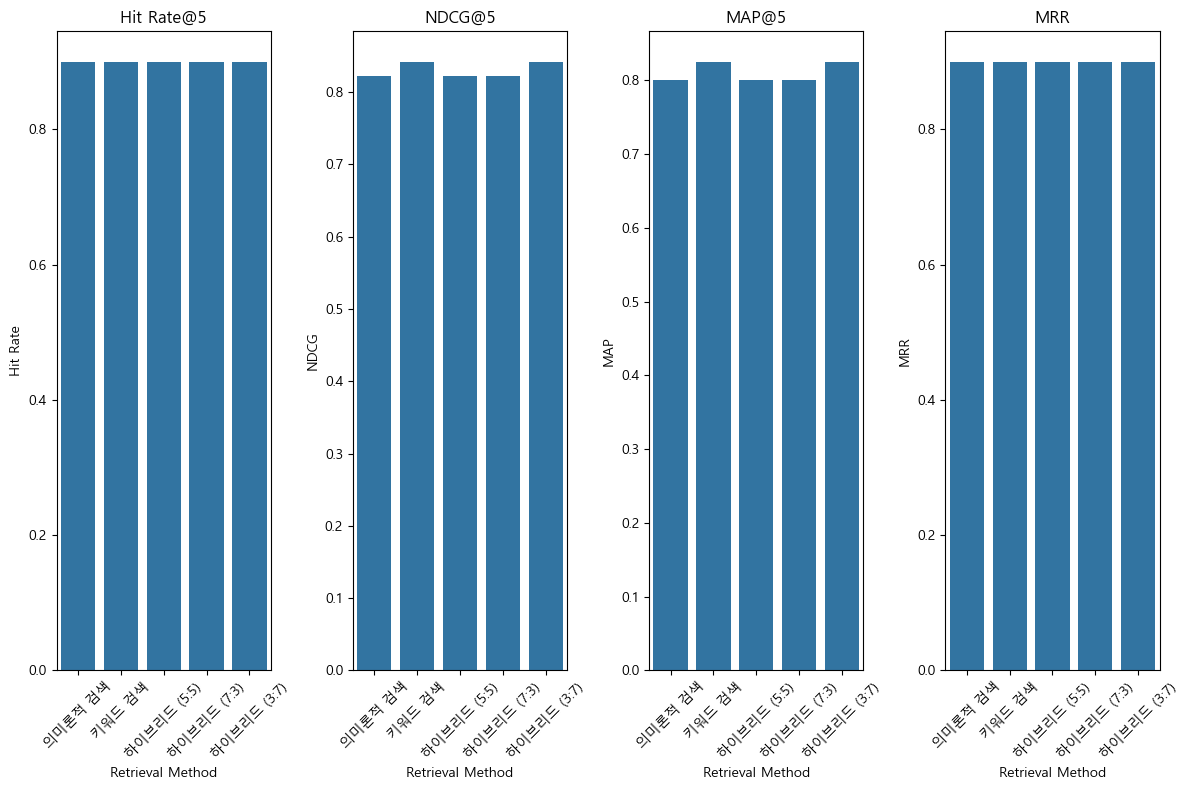

<Figure size 640x480 with 0 Axes>

In [28]:
def visualize_comparison_results(comparison_df):
    """
    검색 방법 비교 결과 시각화
    
    Args:
        comparison_df (pandas.DataFrame): 비교 결과 데이터프레임

        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

    """
    
    # 그래프 생성
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    sns.barplot(x=comparison_df.index, y='hit_rate', data=comparison_df, ax=ax[0])
    ax[0].set_title('Hit Rate@5')
    ax[0].set_ylabel('Hit Rate')
    ax[0].set_xlabel('Retrieval Method')        
    ax[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=comparison_df.index, y='ndcg', data=comparison_df, ax=ax[1])
    ax[1].set_title('NDCG@5')
    ax[1].set_ylabel('NDCG')
    ax[1].set_xlabel('Retrieval Method')
    ax[1].tick_params(axis='x', rotation=45)                

    sns.barplot(x=comparison_df.index, y='map', data=comparison_df, ax=ax[2])
    ax[2].set_title('MAP@5')
    ax[2].set_ylabel('MAP')         
    ax[2].set_xlabel('Retrieval Method')
    ax[2].tick_params(axis='x', rotation=45)    

    sns.barplot(x=comparison_df.index, y='mrr', data=comparison_df, ax=ax[3])
    ax[3].set_title('MRR')
    ax[3].set_ylabel('MRR')
    ax[3].set_xlabel('Retrieval Method')
    ax[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 그래프 출력
    plt.savefig("retrieval_comparison_results.png")

# 검색 방법 비교 결과 시각화
visualize_comparison_results(comparison_results)

---

## 6. 실습 문제

### 🧪 실습 1: 기본 하이브리드 검색 구현

**목표**: 기본적인 하이브리드 검색 시스템을 구축하고 테스트해보세요.

**문제**:
1. 제공된 텍스트 데이터를 사용하여 벡터 저장소와 BM25 검색기를 생성하세요.
2. 동일한 가중치(0.5, 0.5)로 하이브리드 검색기를 만드세요.
3. 다음 질문들에 대해 검색을 수행하고 결과를 비교하세요:
   - "전기차의 장점은 무엇인가요?"
   - "배터리 기술의 발전 현황은?"
   - "자율주행 기능은 어떻게 작동하나요?"

In [ ]:
# 여기에 코드를 작성하세요
def solve_exercise_1():
    # 1. 데이터 로드 및 전처리
    
    # 2. 벡터 저장소 생성
    
    # 3. BM25 검색기 생성
    
    # 4. 하이브리드 검색기 생성
    
    # 5. 검색 테스트
    queries = [
        "전기차의 장점은 무엇인가요?",
        "배터리 기술의 발전 현황은?",
        "자율주행 기능은 어떻게 작동하나요?"
    ]
    
    for query in queries:
        print(f"질문: {query}")
        # 검색 수행 및 결과 출력
        pass

# solve_exercise_1()

### 🧪 실습 2: 가중치 최적화

**목표**: 다양한 가중치 조합을 테스트하여 최적의 성능을 찾아보세요.

**문제**:
1. 가중치 후보: [1.0, 0.0], [0.8, 0.2], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.2, 0.8], [0.0, 1.0]
2. 각 가중치에 대해 테스트 쿼리를 수행하고 성능을 측정하세요.
3. 가장 좋은 성능을 보이는 가중치를 찾아보세요.

In [ ]:
def solve_exercise_2():
    weight_candidates = [
        [1.0, 0.0], [0.8, 0.2], [0.6, 0.4], [0.5, 0.5],
        [0.4, 0.6], [0.2, 0.8], [0.0, 1.0]
    ]
    
    test_queries = [
        # 여기에 테스트 쿼리 추가
    ]
    
    results = []
    for weights in weight_candidates:
        # 하이브리드 검색기 생성
        # 성능 측정
        # 결과 저장
        pass
    
    # 최적 가중치 출력
    return results

# solve_exercise_2()

---

## 📚 참고 자료

- [ranx Documentation](https://github.com/AmenRa/ranx)
- [pytrec_eval Documentation](https://github.com/cvangysel/pytrec_eval)
- [ranx-k Documentation](https://github.com/tsdata/ranx-k)

---